# Analytics Challenge - Rappi

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH='data/Rappi/'

//anaconda/envs/fastai-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
//anaconda/envs/fastai-cpu/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Data Preparation

In [8]:
orders = pd.read_csv(PATH + 'orders_augmented.csv')
orders.taken = orders.taken.astype(np.int32)
orders.am = orders.am.astype(np.int64)
orders.uphill = orders.uphill.astype(np.int64)
orders.set_index('created_at', inplace=True)
orders.index = pd.DatetimeIndex(orders.index)

In [9]:
orders.drop(['order_id', 'year', 'am', 'month'], axis=1, inplace=True)

In [10]:
orders.T

created_at,2017-09-05 00:01:02,2017-09-05 00:11:02,2017-09-05 00:24:02,2017-09-05 00:27:03,2017-09-05 00:33:02,2017-09-05 00:39:02,2017-09-05 00:51:02,2017-09-05 00:51:02,2017-09-05 01:13:02,2017-09-05 01:15:02,...,2017-10-04 23:39:54,2017-10-04 23:39:54,2017-10-04 23:41:53,2017-10-04 23:42:54,2017-10-04 23:44:53,2017-10-04 23:49:54,2017-10-04 23:56:54,2017-10-04 23:56:54,2017-10-04 23:57:53,2017-10-04 23:58:53
store_id,9.000147e+08,9.000020e+08,3.000005e+07,3.000005e+07,9.000124e+08,9.000145e+08,3.000005e+07,9.000127e+08,9.000139e+08,9.000130e+08,...,9.000065e+08,9.000154e+08,9.000130e+08,9.000159e+08,9.000054e+08,9.000051e+08,9.000168e+08,9.000020e+08,9.000051e+08,9.000152e+08
to_user_distance,1.781381e+00,2.930693e-01,1.009802e+00,1.798326e+00,1.576528e-01,3.823988e-01,6.216354e-01,1.005611e+00,2.769410e+00,2.391864e+00,...,7.178331e-01,1.158753e+00,3.552390e+00,3.106475e+00,2.797687e+00,1.314733e+00,2.843349e+00,1.204369e+00,1.555932e+00,1.018662e+00
to_user_elevation,1.391643e+02,-1.764929e+01,-1.211853e+01,1.586998e+02,5.725098e-01,-2.038635e+01,-2.851221e+01,2.154260e+01,3.950708e+01,2.731763e+01,...,7.540869e+01,7.023230e+01,3.520715e+01,-2.676990e+01,-4.169983e+01,2.918848e+01,1.804382e+01,5.947620e+01,3.466724e+01,-1.515771e+01
total_earning,5.200000e+03,7.700000e+03,7.200000e+03,5.200000e+03,5.700000e+03,6.200000e+03,6.200000e+03,5.700000e+03,1.050000e+04,6.700000e+03,...,6.200000e+03,5.200000e+03,8.100000e+03,6.250000e+03,8.050000e+03,7.200000e+03,8.950000e+03,7.200000e+03,6.200000e+03,7.200000e+03
taken,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
day,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
wday,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00
hour,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,...,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01
distance,1.786809e+00,2.936003e-01,1.009875e+00,1.805315e+00,1.576538e-01,3.829419e-01,6.222889e-01,1.005842e+00,2.769692e+00,2.392020e+00,...,7.217831e-01,1.160879e+00,3.552564e+00,3.106590e+00,2.797998e+00,1.315057e+00,2.843406e+00,1.205836e+00,1.556318e+00,1.018775e+00
uphill,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00


In [11]:
cat_vars = ['store_id', 'day', 'wday', 'hour']
cont_vars = ['to_user_distance', 'to_user_elevation', 'total_earning', 'distance']
dep = 'taken'

In [12]:
n = len(orders)
pct_test = 0.15
orders_train = orders.iloc[:int((1 - pct_test) * n)].copy()
orders_test = orders.iloc[int((1 - pct_test) * n):].copy()

In [13]:
for v in cat_vars: orders_train[v] = orders_train[v].astype('category').cat.as_ordered()

In [14]:
apply_cats(orders_test, orders_train)

In [15]:
for v in cont_vars:
    orders_train[v] = orders_train[v].fillna(0).astype('float32')
    orders_test[v] = orders_test[v].fillna(0).astype('float32')

In [16]:
df, y, nas, mapper = proc_df(orders_train, dep, do_scale=True)

In [17]:
df_test, y_test, nas, mapper = proc_df(orders_test, dep, do_scale=True,
                                       mapper=mapper, na_dict=nas)

In [18]:
df.head()

,store_id,to_user_distance,to_user_elevation,total_earning,day,wday,hour,distance,uphill
created_at,,,,,,,,,
2017-09-05 00:01:02,631,0.339485,1.332154,-0.083696,1,2,1,0.342965,0.823455
2017-09-05 00:11:02,94,-1.430522,-0.525451,1.325241,1,2,1,-1.431735,-1.214395
2017-09-05 00:24:02,14,-0.578132,-0.459934,1.043454,1,2,1,-0.580432,-1.214395
2017-09-05 00:27:03,14,0.359637,1.563571,-0.083696,1,2,1,0.364961,0.823455
2017-09-05 00:33:02,446,-1.591569,-0.309596,0.198092,1,2,1,-1.593310,0.823455


In [19]:
val_idx = list(range(len(df) - len(df_test), len(df)))
val_idx[:10]

[102889,
 102890,
 102891,
 102892,
 102893,
 102894,
 102895,
 102896,
 102897,
 102898]

# DL

## Modifications

See: https://github.com/KeremTurgutlu/deeplearning/blob/master/avazu/FAST.AI%20Classification%20-%20Kaggle%20Avazu%20CTR.ipynb.

In [43]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.n_emb, self.n_cont=n_emb, n_cont
        
        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x2 = self.bn(x_cont)
            x = torch.cat([x, x2], 1) if self.n_emb != 0 else x2
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x
    
class ColumnarDataset(Dataset):
    def __init__(self, cats, conts, y):
        n = len(cats[0]) if cats else len(conts[0])
        self.cats = np.stack(cats, 1).astype(np.int64) if cats else np.zeros((n,1))
        self.conts = np.stack(conts, 1).astype(np.float32) if conts else np.zeros((n,1))
        self.y = np.zeros((n,1)) if y is None else y.values # THIS LINE IS CHANGED FROM y[:, None]
        
    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return [self.cats[idx], self.conts[idx], self.y[idx]]

    @classmethod
    def from_data_frames(cls, df_cat, df_cont, y=None):
        cat_cols = [c.values for n,c in df_cat.items()]
        cont_cols = [c.values for n,c in df_cont.items()]
        return cls(cat_cols, cont_cols, y)

    @classmethod
    def from_data_frame(cls, df, cat_flds, y=None):
        return cls.from_data_frames(df[cat_flds], df.drop(cat_flds, axis=1), y)
    

class ColumnarModelData(ModelData):
    def __init__(self, path, trn_ds, val_ds, bs, test_ds=None, shuffle=True):
        test_dl = DataLoader(test_ds, bs, shuffle=False, num_workers=1) if test_ds is not None else None
        super().__init__(path, DataLoader(trn_ds, bs, shuffle=shuffle, num_workers=1),
            DataLoader(val_ds, bs*2, shuffle=False, num_workers=1), test_dl)

    @classmethod
    def from_arrays(cls, path, val_idxs, xs, y, bs=64, test_xs=None, shuffle=True):
        ((val_xs, trn_xs), (val_y, trn_y)) = split_by_idx(val_idxs, xs, y)
        test_ds = PassthruDataset(*(test_xs.T), [0] * len(test_xs)) if test_xs is not None else None
        return cls(path, PassthruDataset(*(trn_xs.T), trn_y), PassthruDataset(*(val_xs.T), val_y),
                   bs=bs, shuffle=shuffle, test_ds=test_ds)

    @classmethod
    def from_data_frames(cls, path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=None):
        test_ds = ColumnarDataset.from_data_frame(test_df, cat_flds) if test_df is not None else None
        return cls(path, ColumnarDataset.from_data_frame(trn_df, cat_flds, trn_y),
                    ColumnarDataset.from_data_frame(val_df, cat_flds, val_y), bs, test_ds=test_ds)

    @classmethod
    def from_data_frame(cls, path, val_idxs, df, y, cat_flds, bs, test_df=None):
        ((val_df, trn_df), (val_y, trn_y)) = split_by_idx(val_idxs, df, y)
        return cls.from_data_frames(path, trn_df, val_df, trn_y, val_y, cat_flds, bs, test_df=test_df)

    def get_learner(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                    y_range=None, use_bn=False, **kwargs):
        model = MixedInputModel(emb_szs, n_cont, emb_drop, out_sz, szs, drops, y_range, use_bn)
        return StructuredLearner(self, StructuredModel(to_gpu(model)), opt_fn=optim.Adam, **kwargs)

## Fitting 

In [44]:
cat_sz = [(c, len(orders_train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('store_id', 812), ('day', 27), ('wday', 8), ('hour', 25)]

In [45]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(812, 50), (27, 14), (8, 4), (25, 13)]

In [46]:
model = MixedInputModel(emb_szs, n_cont=len(df.columns)-len(cat_vars),
                        emb_drop=0, out_sz=2, szs=[500], drops=[0.5])

In [47]:
bm = BasicModel(model, 'binary_classifier')

In [68]:
model

MixedInputModel(
  (embs): ModuleList(
    (0): Embedding(812, 50)
    (1): Embedding(27, 14)
    (2): Embedding(8, 4)
    (3): Embedding(25, 13)
  )
  (lins): ModuleList(
    (0): Linear(in_features=86, out_features=500, bias=True)
  )
  (bns): ModuleList(
    (0): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True)
  )
  (outp): Linear(in_features=500, out_features=2, bias=True)
  (emb_drop): Dropout(p=0)
  (drops): ModuleList(
    (0): Dropout(p=0.5)
  )
  (bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
)

In [49]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, orders_train.taken, cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [50]:
# you can simply create learner with any custom model and data
# source code is here
class StructuredLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss


learn = StructuredLearner(md, bm)

In [51]:
learn.crit = F.cross_entropy
learn.crit

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True)>

In [72]:
learn.lr_find()

 89%|████████▉ | 715/804 [00:06<00:00, 116.98it/s, loss=0.278]


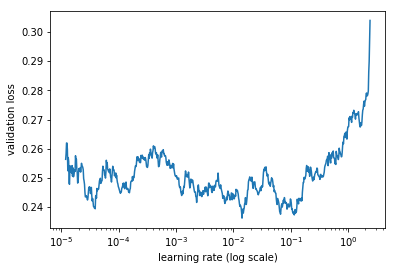

In [73]:
learn.sched.plot()

## Fitting 

In [55]:
lr = 1e-2
learn.fit(lr, 3)

epoch      trn_loss   val_loss                                
    0      0.265506   0.28218   
    1      0.254794   0.277034                                
    2      0.258504   0.274652                                



[array([0.27465])]

In [74]:
learn.fit(lr, 5, cycle_len=2)

epoch      trn_loss   val_loss                                
    0      0.247308   0.267389  
    1      0.242139   0.266409                                
    2      0.248787   0.267128                                
    3      0.239688   0.266071                                
    4      0.239044   0.264605                                
    5      0.253714   0.264834                                
    6      0.247429   0.264059                                
    7      0.237182   0.264169                                
    8      0.239228   0.263407                               
    9      0.242193   0.263273                                



[array([0.26327])]

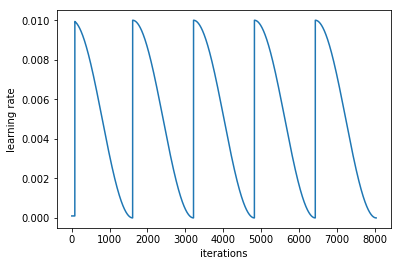

In [75]:
learn.sched.plot_lr()

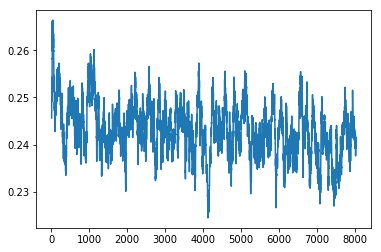

In [76]:
learn.scheded.plot_loss()

In [77]:
from sklearn.metrics import confusion_matrix

In [78]:
preds = learn.predict(True)

In [79]:
# softmax
expsums = np.exp(preds).sum(axis=1)
probs = np.exp(preds) / expsums[:, None]

In [80]:
y_pred = probs.argmax(axis=1)

In [81]:
confusion_matrix(y_test.astype(np.int32), y_pred)

array([[    7,  1691],
       [   13, 20338]])